### Prepared Training Datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the preprocessed data
df_processed = pd.read_csv("../data/processed_rain_data.csv")
print("Processed Dataset shape:", df_processed.shape)
print("\nColumn names:", df_processed.columns.tolist())
print("\nFirst few rows:")
print(df_processed.head())


Processed Dataset shape: (7084, 91)

Column names: ['YEAR', 'MONTH', 'PROV_ID', 'MinRain', 'MaxRain', 'AvgRain', 'RainRange', 'RainVariability', 'IsRainySeason', 'Province_กรุงเทพมหานคร', 'Province_กาญจนบุรี', 'Province_กาฬสินธุ์', 'Province_กำแพงเพชร', 'Province_ขอนแก่น', 'Province_จันทบุรี', 'Province_ฉะเชิงเทรา', 'Province_ชลบุรี', 'Province_ชัยนาท', 'Province_ชัยภูมิ', 'Province_ชุมพร', 'Province_ตรัง', 'Province_ตราด', 'Province_ตาก', 'Province_นครนายก', 'Province_นครปฐม', 'Province_นครพนม', 'Province_นครราชสีมา', 'Province_นครศรีธรรมราช', 'Province_นครสวรรค์', 'Province_นนทบุรี', 'Province_นราธิวาส', 'Province_น่าน', 'Province_บึงกาฬ', 'Province_บุรีรัมย์', 'Province_ปทุมธานี', 'Province_ประจวบคีรีขันธ์', 'Province_ปราจีนบุรี', 'Province_ปัตตานี', 'Province_พระนครศรีอยุธยา', 'Province_พะเยา', 'Province_พังงา', 'Province_พัทลุง', 'Province_พิจิตร', 'Province_พิษณุโลก', 'Province_ภูเก็ต', 'Province_มหาสารคาม', 'Province_มุกดาหาร', 'Province_ยะลา', 'Province_ยโสธร', 'Province_ระนอง'

### Create Classification Target: Rain/No Rain for Next Month

In [3]:
# Create a copy for classification preprocessing
df_classification = df_processed.copy()

# Sort by province and date to create time series
df_classification = df_classification.sort_values(['PROV_ID', 'YEAR', 'MONTH']).reset_index(drop=True)

# Create target variable: Will it rain next month?
# Define rain threshold (you can adjust this value)
RAIN_THRESHOLD = 0.1  # Rain if AvgRain > 0.1 (scaled value)

# Create next month's rain target
df_classification['next_month_rain'] = df_classification.groupby('PROV_ID')['AvgRain'].shift(-1)
df_classification['rain_next_month'] = (df_classification['next_month_rain'] > RAIN_THRESHOLD).astype(int)

# Remove rows where we don't have next month data
df_classification = df_classification.dropna(subset=['next_month_rain'])

print(f"Classification dataset shape: {df_classification.shape}")
print(f"Rain distribution for next month:")
print(df_classification['rain_next_month'].value_counts())
print(f"Rain percentage: {df_classification['rain_next_month'].mean():.2%}")


Classification dataset shape: (7007, 93)
Rain distribution for next month:
rain_next_month
0    4314
1    2693
Name: count, dtype: int64
Rain percentage: 38.43%


### Feature Selection and Data Preparation

In [4]:
# Select features (exclude target and future information)
feature_cols = [col for col in df_classification.columns if col not in [
    'rain_next_month', 'next_month_rain', 'AvgRain'  # Remove current AvgRain to avoid data leakage
]]

X = df_classification[feature_cols]
y = df_classification['rain_next_month']

print(f"Features selected: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")


Features selected: 90
Feature columns: ['YEAR', 'MONTH', 'PROV_ID', 'MinRain', 'MaxRain', 'RainRange', 'RainVariability', 'IsRainySeason', 'Province_กรุงเทพมหานคร', 'Province_กาญจนบุรี']...
Target distribution: {0: 4314, 1: 2693}

Data split completed:
Training set: (5605, 90)
Test set: (1402, 90)
Training target distribution: {0: 3451, 1: 2154}
Test target distribution: {0: 863, 1: 539}


## Model 1: Random Forest Classifier

In [5]:
# Initialize and train Random Forest
print("=== RANDOM FOREST CLASSIFIER ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
print("Random Forest - Training Accuracy:", rf_model.score(X_train, y_train))
print("Random Forest - Test Accuracy:", rf_model.score(X_test, y_test))
print("\nRandom Forest - Classification Report (Test Set):")
print(classification_report(y_test, rf_test_pred))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))


=== RANDOM FOREST CLASSIFIER ===
Random Forest - Training Accuracy: 0.8429973238180196
Random Forest - Test Accuracy: 0.8266761768901569

Random Forest - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       863
           1       0.71      0.92      0.80       539

    accuracy                           0.83      1402
   macro avg       0.83      0.84      0.82      1402
weighted avg       0.85      0.83      0.83      1402


Top 10 Most Important Features (Random Forest):
          feature  importance
3         MinRain    0.135674
4         MaxRain    0.121390
85  Season_Summer    0.115182
5       RainRange    0.096572
1           MONTH    0.092993
86  Season_Winter    0.079559
89            Q_4    0.049828
87            Q_2    0.048625
88            Q_3    0.046977
2         PROV_ID    0.045187


## Model 2: Decision Tree Classifier

In [6]:
# Initialize and train Decision Tree
print("\n=== DECISION TREE CLASSIFIER ===")
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)
dt_test_proba = dt_model.predict_proba(X_test)[:, 1]

# Evaluate Decision Tree
print("Decision Tree - Training Accuracy:", dt_model.score(X_train, y_train))
print("Decision Tree - Test Accuracy:", dt_model.score(X_test, y_test))
print("\nDecision Tree - Classification Report (Test Set):")
print(classification_report(y_test, dt_test_pred))

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Decision Tree):")
print(feature_importance_dt.head(10))



=== DECISION TREE CLASSIFIER ===
Decision Tree - Training Accuracy: 0.8667261373773416
Decision Tree - Test Accuracy: 0.8295292439372325

Decision Tree - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       863
           1       0.73      0.88      0.80       539

    accuracy                           0.83      1402
   macro avg       0.82      0.84      0.83      1402
weighted avg       0.84      0.83      0.83      1402


Top 10 Most Important Features (Decision Tree):
          feature  importance
4         MaxRain    0.441553
2         PROV_ID    0.138863
0            YEAR    0.093890
85  Season_Summer    0.084600
1           MONTH    0.083357
87            Q_2    0.061660
84  Season_Spring    0.022616
3         MinRain    0.016298
5       RainRange    0.015550
88            Q_3    0.015065


## Model 3: Logistic Regression Classifier

In [7]:
# Initialize and train Logistic Regression
print("\n=== LOGISTIC REGRESSION CLASSIFIER ===")
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_test_proba = lr_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression - Training Accuracy:", lr_model.score(X_train, y_train))
print("Logistic Regression - Test Accuracy:", lr_model.score(X_test, y_test))
print("\nLogistic Regression - Classification Report (Test Set):")
print(classification_report(y_test, lr_test_pred))

# Feature coefficients (importance)
feature_importance_lr = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features (Logistic Regression):")
print(feature_importance_lr.head(10)[['feature', 'coefficient']])



=== LOGISTIC REGRESSION CLASSIFIER ===
Logistic Regression - Training Accuracy: 0.8174843889384478
Logistic Regression - Test Accuracy: 0.8109843081312411

Logistic Regression - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       863
           1       0.72      0.84      0.77       539

    accuracy                           0.81      1402
   macro avg       0.80      0.82      0.81      1402
weighted avg       0.82      0.81      0.81      1402


Top 10 Most Important Features (Logistic Regression):
              feature  coefficient
4             MaxRain     3.291494
5           RainRange     2.473181
3             MinRain     2.405298
88                Q_3     2.230398
86      Season_Winter    -1.976574
87                Q_2     1.656394
85      Season_Summer     1.590832
20      Province_ตราด     1.582331
50   Province_ราชบุรี    -1.482146
79  Province_เพชรบุรี    -1.425769


## Model Comparison and Evaluation

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import os

# Create comparison dataframe
model_results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression'],
    'Train_Accuracy': [
        accuracy_score(y_train, rf_train_pred),
        accuracy_score(y_train, dt_train_pred),
        accuracy_score(y_train, lr_train_pred)
    ],
    'Test_Accuracy': [
        accuracy_score(y_test, rf_test_pred),
        accuracy_score(y_test, dt_test_pred),
        accuracy_score(y_test, lr_test_pred)
    ],
    'Precision': [
        precision_score(y_test, rf_test_pred),
        precision_score(y_test, dt_test_pred),
        precision_score(y_test, lr_test_pred)
    ],
    'Recall': [
        recall_score(y_test, rf_test_pred),
        recall_score(y_test, dt_test_pred),
        recall_score(y_test, lr_test_pred)
    ],
    'F1_Score': [
        f1_score(y_test, rf_test_pred),
        f1_score(y_test, dt_test_pred),
        f1_score(y_test, lr_test_pred)
    ],
    'ROC_AUC': [
        roc_auc_score(y_test, rf_test_proba),
        roc_auc_score(y_test, dt_test_proba),
        roc_auc_score(y_test, lr_test_proba)
    ]
})

print("=== MODEL COMPARISON ===")
print(model_results.round(4))

# Find best model
best_model_idx = model_results['F1_Score'].idxmax()
best_model_name = model_results.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-Score: {model_results.loc[best_model_idx, 'F1_Score']:.4f}")


=== MODEL COMPARISON ===
                 Model  Train_Accuracy  Test_Accuracy  Precision  Recall  \
0        Random Forest          0.8430         0.8267     0.7133  0.9184   
1        Decision Tree          0.8667         0.8295     0.7329  0.8757   
2  Logistic Regression          0.8175         0.8110     0.7168  0.8404   

   F1_Score  ROC_AUC  
0    0.8029   0.9194  
1    0.7980   0.9107  
2    0.7737   0.8999  

Best performing model: Random Forest
Best F1-Score: 0.8029


## Confusion Matrices Visualization

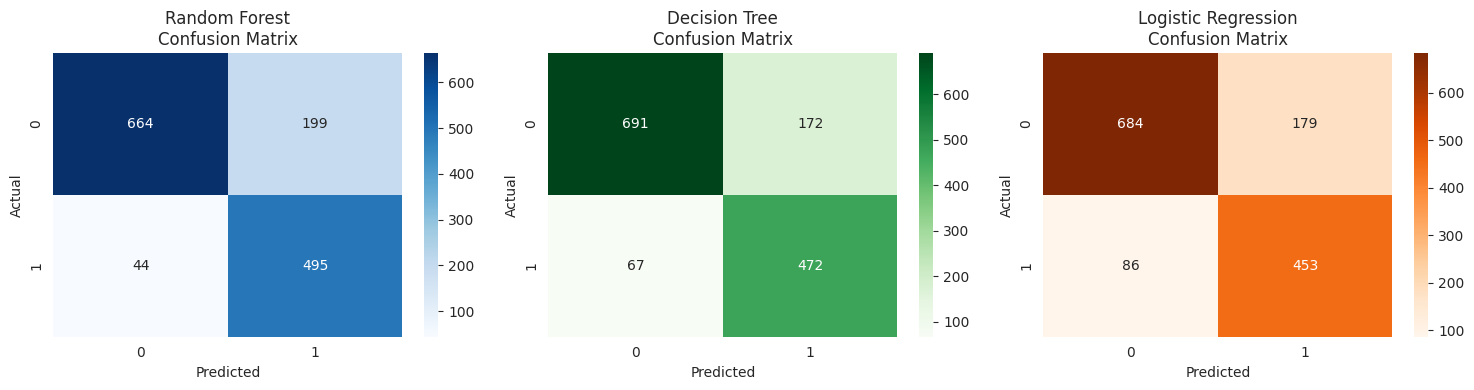

In [9]:
# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_test_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Decision Tree\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('Logistic Regression\nConfusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


## Model Performance Visualization

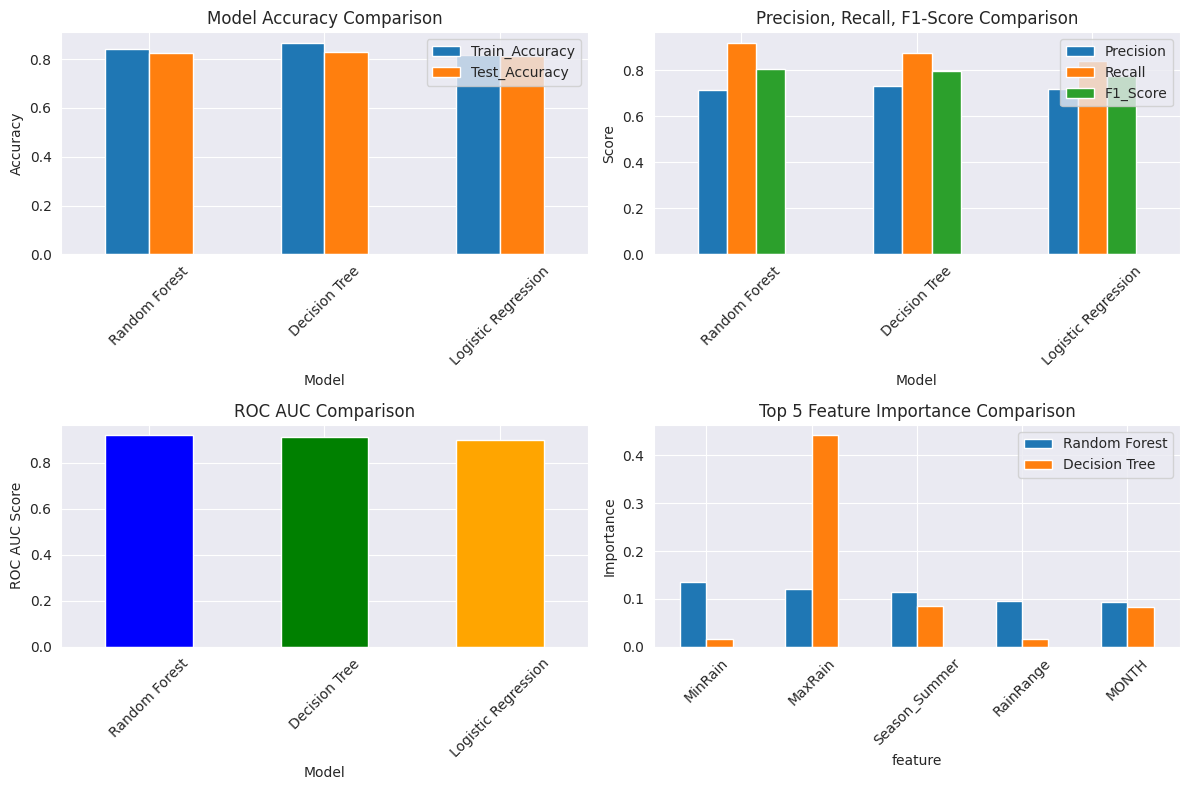

In [10]:
# Model comparison bar plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Accuracy comparison
model_results.set_index('Model')[['Train_Accuracy', 'Test_Accuracy']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Precision, Recall, F1 comparison
model_results.set_index('Model')[['Precision', 'Recall', 'F1_Score']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Precision, Recall, F1-Score Comparison')
axes[0,1].set_ylabel('Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# ROC AUC comparison
model_results.set_index('Model')['ROC_AUC'].plot(kind='bar', ax=axes[1,0], color=['blue', 'green', 'orange'])
axes[1,0].set_title('ROC AUC Comparison')
axes[1,0].set_ylabel('ROC AUC Score')
axes[1,0].tick_params(axis='x', rotation=45)

# Feature importance comparison (top 5 features)
top_features = feature_importance_rf.head(5)['feature'].tolist()
importance_comparison = pd.DataFrame({
    'Random Forest': feature_importance_rf.set_index('feature').loc[top_features, 'importance'],
    'Decision Tree': feature_importance_dt.set_index('feature').loc[top_features, 'importance']
})
importance_comparison.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Top 5 Feature Importance Comparison')
axes[1,1].set_ylabel('Importance')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Save Models and Results

In [11]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained models
models_to_save = {
    'random_forest': rf_model,
    'decision_tree': dt_model,
    'logistic_regression': lr_model
}

for model_name, model in models_to_save.items():
    model_path = f'models/{model_name}_rain_classifier.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {model_name} model to {model_path}")

# Save model comparison results
model_results.to_csv('models/model_comparison_results.csv', index=False)
print("Saved model comparison results to models/model_comparison_results.csv")

# Save feature importance
feature_importance_rf.to_csv('models/feature_importance_rf.csv', index=False)
feature_importance_dt.to_csv('models/feature_importance_dt.csv', index=False)
feature_importance_lr.to_csv('models/feature_importance_lr.csv', index=False)
print("Saved feature importance files")

print("\n=== CLASSIFICATION MODELS TRAINING COMPLETED ===")
print(f"All 3 models trained successfully to predict rain/no-rain for next month")
print(f"Best model: {best_model_name} with F1-Score: {model_results.loc[best_model_idx, 'F1_Score']:.4f}")
print("Models and results saved in the 'models' directory")


Saved random_forest model to models/random_forest_rain_classifier.pkl
Saved decision_tree model to models/decision_tree_rain_classifier.pkl
Saved logistic_regression model to models/logistic_regression_rain_classifier.pkl
Saved model comparison results to models/model_comparison_results.csv
Saved feature importance files

=== CLASSIFICATION MODELS TRAINING COMPLETED ===
All 3 models trained successfully to predict rain/no-rain for next month
Best model: Random Forest with F1-Score: 0.8029
Models and results saved in the 'models' directory
